In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model 

# from tensorflow.keras.optimizers.legacy import RMSprop

# from tensorflow.keras.optimizers.legacy import Adam

import random

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

## global variables

In [ ]:
file_dir = '/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/data/solar_weather copy 2.csv'
output_folder = 'assets/arch'
os.makedirs(output_folder, exist_ok=True)

time_step = 24
num_feats = 5
evaluation_results = []


neurons = 250
epochs = 10
batch_size = 64



## helper functions

In [34]:
# Modified evaluate_model function to store results in evaluation_results



def evaluate_model(y_true, y_pred, model_name, dataset_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Append metrics to evaluation_results
    evaluation_results.append({
        'Model': model_name,
        'Dataset': dataset_type,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

# Step 4: Prepare data for BiLSTM
def create_dataset(dataset, time_step):
    print(f'dataset shape {dataset.shape}')
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]  # Features: GHI and Energy delta
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Target: Energy delta
    return np.array(dataX), np.array(dataY)

def build_bilstm_model(time_step):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(time_step, num_feats))))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(1)) # output layer
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_learning_curve(history, model_name):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.figure(figsize=(10,6))
  plt.plot(epochs, loss, 'b-', label='Training Loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
  plt.title(f'Learning curve: {model_name}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  save_path = os.path.join('/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/GBDT-BILSTM/assets/learning_curves/multi_variate', f'{model_name}_learning_curve.png')
  plt.savefig(save_path)
  print(f'plot saved to {save_path}')
  plt.show()
  plt.close()

In [35]:
# from sklearn.model_selection import train_test_split

# Load and split data
data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])

# data = data[(data.index.month.isin([6, 7, 8])) & (data.index.year == 2021)]
year = 2021

data = data[(data.index.year == year)]

dataset = data[['GHI', 'temp', 'pressure', 'humidity']]
# dataset = data[['Energy delta[Wh]', 'GHI']]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_39815/3654564369.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])


## Base BiLSTM

In [5]:
# data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])

# # data = data[(data.index.month.isin([6, 7, 8])) & (data.index.year == 2021)]

# data = data[(data.index.year == 2021)]

# dataset = data[['GHI', 'temp', 'pressure', 'humidity']]
# # dataset = data[['Energy delta[Wh]', 'GHI']]


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

# Function to create sequences with time steps
# def create_dataset(dataset, time_step=1):
def create_dataset(dataset, time_step):
    print(f'dataset shape {dataset.shape}')
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]  # Features: GHI and Energy delta
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Target: Energy delta
    return np.array(dataX), np.array(dataY)

# Set time_step (lookback window for BiLSTM)
time_step = 24  # Predict based on past 24 hours (1 day)
X, y = create_dataset(scaled_data, time_step)
print(f'X, y shape {X.shape} {y.shape}')
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

dataset shape (34368, 4)
X, y shape (34344, 24, 4) (34344,)


In [6]:
print("Training BiLSTM only...")
print("\n")

model = build_bilstm_model(time_step)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

y_train_predict = scaler.inverse_transform(
    np.concatenate([y_train_predict, X_train[:, -1, 1:]], axis=1)
)[:, 0]

y_test_predict = scaler.inverse_transform(
    np.concatenate([y_test_predict, X_test[:, -1, 1:]], axis=1)
)[:, 0]

y_train_actual = scaler.inverse_transform(
    np.concatenate([y_train.reshape(-1, 1), X_train[:, -1, 1:]], axis=1)
)[:, 0]

y_test_actual = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), X_test[:, -1, 1:]], axis=1)
)[:, 0]

evaluate_model(y_train_actual, y_train_predict, 'BiLSTM', 'Training')
evaluate_model(y_test_actual, y_test_predict, 'BiLSTM', 'Testing')

Training BiLSTM only...


Epoch 1/10
430/430 [==============================] - 117s 266ms/step - loss: 0.0045 - val_loss: 3.8621e-04
Epoch 2/10
430/430 [==============================] - 119s 277ms/step - loss: 0.0021 - val_loss: 7.2292e-04
Epoch 3/10
430/430 [==============================] - 124s 287ms/step - loss: 0.0020 - val_loss: 3.0316e-04
Epoch 4/10
430/430 [==============================] - 128s 298ms/step - loss: 0.0018 - val_loss: 3.0509e-04
Epoch 5/10
430/430 [==============================] - 126s 292ms/step - loss: 0.0018 - val_loss: 4.3259e-04
Epoch 6/10
430/430 [==============================] - 61s 141ms/step - loss: 0.0018 - val_loss: 2.9141e-04
Epoch 7/10
430/430 [==============================] - 58s 134ms/step - loss: 0.0017 - val_loss: 3.2566e-04
Epoch 8/10
430/430 [==============================] - 57s 133ms/step - loss: 0.0017 - val_loss: 3.6141e-04
Epoch 9/10
430/430 [==============================] - 58s 136ms/step - loss: 0.0017 - val_loss: 4.2280e-04
Epoch 

In [7]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Training,4.797767,72.051839,8.488335,0.974514
1,BiLSTM,Testing,3.355258,22.697167,4.764154,0.908103


plot saved to /Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/GBDT-BILSTM/assets/learning_curves/multi_variate/BiLSTM_learning_curve.png


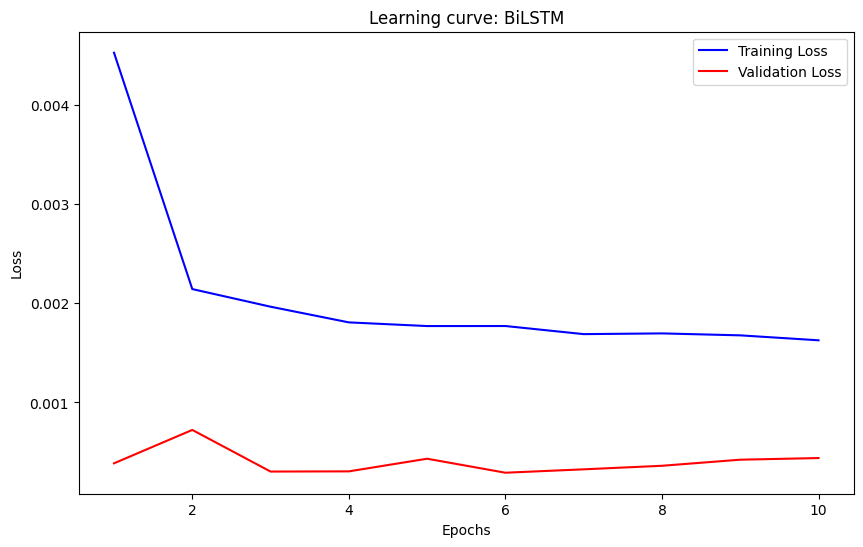

In [8]:
plot_learning_curve(history, 'BiLSTM')

## GBDT-BiLSTM

In [36]:
X = dataset.iloc[:, 1:].values  # Features
y = dataset.iloc[:, 0].values   # Target

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [37]:
# Step 1: Train GBDT, XGB, and CatBoost on the training data
gbdt = GradientBoostingRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

gbdt.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
gbdt_output_train = gbdt.predict(X_train)
gbdt_output_test = gbdt.predict(X_test)

In [38]:
# Evaluate model performance on training and test sets
evaluate_model(y_train, gbdt_output_train, 'GBDT', 'Training')
evaluate_model(y_test, gbdt_output_test, 'GBDT', 'Testing')

In [39]:


# Step 3: Scale the model outputs
scaler = MinMaxScaler()
gbdt_output_train_scaled = scaler.fit_transform(gbdt_output_train.reshape(-1, 1))
gbdt_output_test_scaled = scaler.transform(gbdt_output_test.reshape(-1, 1))

# Create BiLSTM input for all three model outputs
X_train_bilstm_gbdt, y_train_bilstm_gbdt = create_dataset(gbdt_output_train_scaled, time_step)
X_test_bilstm_gbdt, y_test_bilstm_gbdt = create_dataset(gbdt_output_test_scaled, time_step)

# Reshape X to be (samples, time_steps, features)
X_train_bilstm_gbdt = X_train_bilstm_gbdt.reshape(X_train_bilstm_gbdt.shape[0], time_step, 1)
X_test_bilstm_gbdt = X_test_bilstm_gbdt.reshape(X_test_bilstm_gbdt.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on GBDT outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_gbdt = model.fit(X_train_bilstm_gbdt, y_train_bilstm_gbdt, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_gbdt, y_test_bilstm_gbdt), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_gbdt_scaled = model.predict(X_test_bilstm_gbdt)

y_pred_bilstm_gbdt = scaler.inverse_transform(y_pred_bilstm_gbdt_scaled)
y_test_bilstm_gbdt_actual_rescaled = scaler.inverse_transform(y_test_bilstm_gbdt.reshape(-1, 1))

evaluate_model(y_test_bilstm_gbdt_actual_rescaled, y_pred_bilstm_gbdt, 'BiLSTM (GBDT)', 'Testing')

dataset shape (27494, 1)
dataset shape (6874, 1)
Training BiLSTM on GBDT outputs...


Epoch 1/10
430/430 [==============================] - 52s 118ms/step - loss: 0.0037 - val_loss: 4.2266e-04
Epoch 2/10
430/430 [==============================] - 54s 125ms/step - loss: 0.0019 - val_loss: 5.2074e-04
Epoch 3/10
430/430 [==============================] - 49s 115ms/step - loss: 0.0019 - val_loss: 2.5965e-04
Epoch 4/10
430/430 [==============================] - 95s 222ms/step - loss: 0.0017 - val_loss: 2.7314e-04
Epoch 5/10
 74/430 [====>.........................] - ETA: 1:38 - loss: 0.0017

KeyboardInterrupt: 

In [ ]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'BiLSTM (GBDT)']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
4,BiLSTM (GBDT),Testing,0.142066,0.070496,0.265511,0.941633


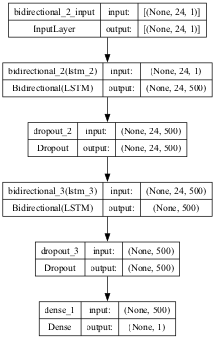

In [ ]:
# Plotting the model architecture
output_path = os.path.join(output_folder, "bilstm_gbdt.png")

plot_model(model, to_file=output_path, show_shapes=True, show_layer_names=True, dpi=50)


plot saved to /Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/GBDT-BILSTM/assets/learning_curves/multi_variate/BiLSTM-gbdt_learning_curve.png


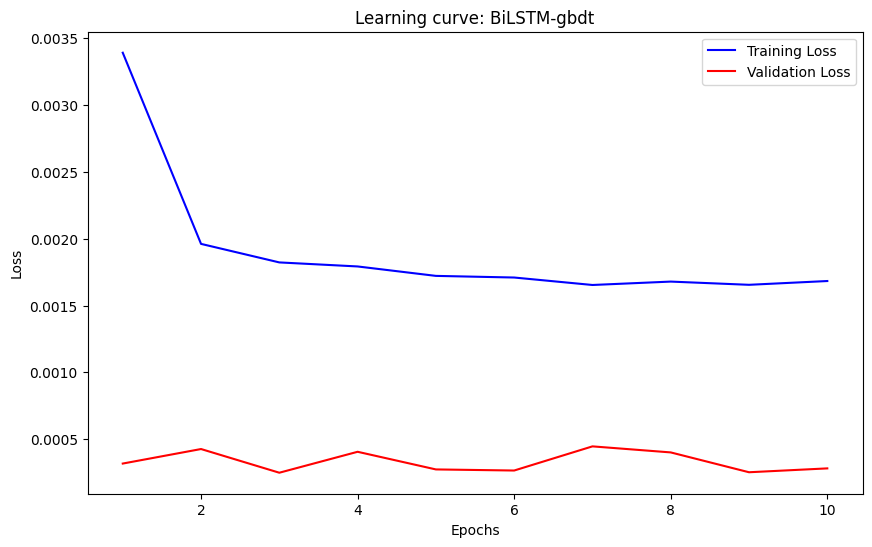

In [ ]:
plot_learning_curve(history_gbdt, 'BiLSTM-gbdt')

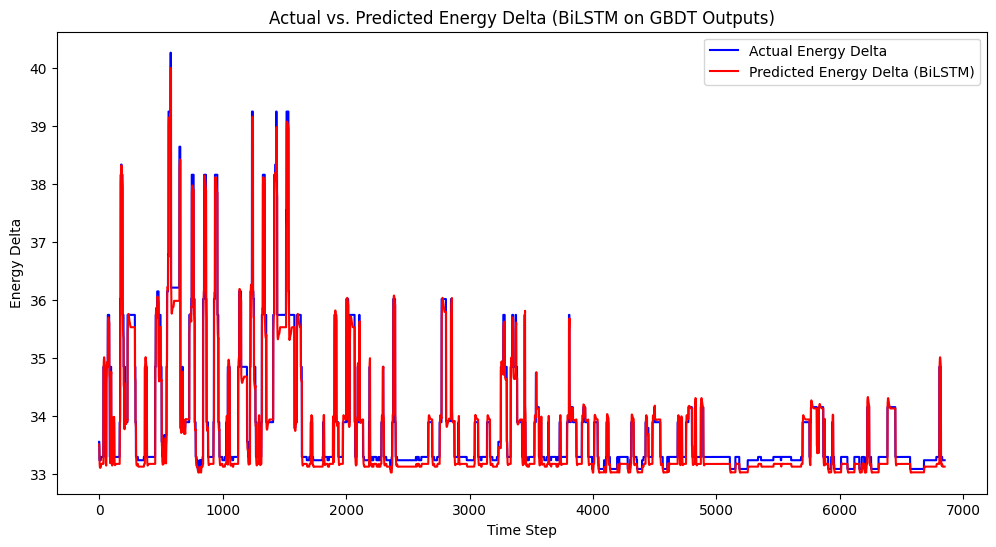

In [ ]:
import matplotlib.pyplot as plt

dates = pd.date_range(start=f"{year}-01-01", periods=len(y_test_bilstm_gbdt_actual_rescaled), freq="M")

plt.figure(figsize=(12, 6))
plt.plot(dates,y_test_bilstm_gbdt_actual_rescaled, label="Actual GHI", color="blue")
plt.plot(dates, y_pred_bilstm_gbdt, label="Predicted GHI (BiLSTM)", color="red")
plt.title("Actual vs. Predicted GHI (BiLSTM on GBDT Outputs)")
plt.xlabel("Month & Year")
plt.ylabel("GHI")
plt.legend()
plt.show()

In [17]:

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data

xgb = XGBRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

xgb.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
xgb_output_train = xgb.predict(X_train)
xgb_output_test = xgb.predict(X_test)

evaluate_model(y_train, xgb_output_train, 'XGB', 'Training')
evaluate_model(y_test, xgb_output_test, 'XGB', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()

xgb_output_train_scaled = scaler.fit_transform(xgb_output_train.reshape(-1, 1))
xgb_output_test_scaled = scaler.transform(xgb_output_test.reshape(-1, 1))


# Create BiLSTM input for all three model outputs

X_train_bilstm_xgb, y_train_bilstm_xgb = create_dataset(xgb_output_train_scaled, time_step)
X_test_bilstm_xgb, y_test_bilstm_xgb = create_dataset(xgb_output_test_scaled, time_step)

X_train_bilstm_xgb = X_train_bilstm_xgb.reshape(X_train_bilstm_xgb.shape[0], time_step, 1)
X_test_bilstm_xgb = X_test_bilstm_xgb.reshape(X_test_bilstm_xgb.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs

print("Training BiLSTM on XGB outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_xgb = model.fit(X_train_bilstm_xgb, y_train_bilstm_xgb, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_xgb, y_test_bilstm_xgb), verbose=1)

# Step 7: Predict with BiLSTM

y_pred_bilstm_xgb_scaled = model.predict(X_test_bilstm_xgb)
y_pred_bilstm_xgb = scaler.inverse_transform(y_pred_bilstm_xgb_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_xgb_actual_rescaled = scaler.inverse_transform(y_test_bilstm_xgb.reshape(-1, 1))

evaluate_model(y_test_bilstm_xgb_actual_rescaled, y_pred_bilstm_xgb, 'BiLSTM (XGB)', 'Testing')

dataset shape (27494, 1)
dataset shape (6874, 1)
Training BiLSTM on XGB outputs...


Epoch 1/10
430/430 [==============================] - 51s 114ms/step - loss: 0.0042 - val_loss: 3.2271e-04
Epoch 2/10
430/430 [==============================] - 56s 130ms/step - loss: 0.0021 - val_loss: 2.9929e-04
Epoch 3/10
430/430 [==============================] - 57s 132ms/step - loss: 0.0020 - val_loss: 3.6670e-04
Epoch 4/10
430/430 [==============================] - 57s 132ms/step - loss: 0.0020 - val_loss: 3.0204e-04
Epoch 5/10
430/430 [==============================] - 57s 132ms/step - loss: 0.0019 - val_loss: 3.0870e-04
Epoch 6/10
430/430 [==============================] - 57s 133ms/step - loss: 0.0019 - val_loss: 3.8835e-04
Epoch 7/10
430/430 [==============================] - 55s 127ms/step - loss: 0.0019 - val_loss: 3.3180e-04
Epoch 8/10
430/430 [==============================] - 55s 127ms/step - loss: 0.0019 - val_loss: 2.8442e-04
Epoch 9/10
430/430 [==============================] - 57s 1

plot saved to /Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/GBDT-BILSTM/assets/learning_curves/multi_variate/BiLSTM-xgb_learning_curve.png


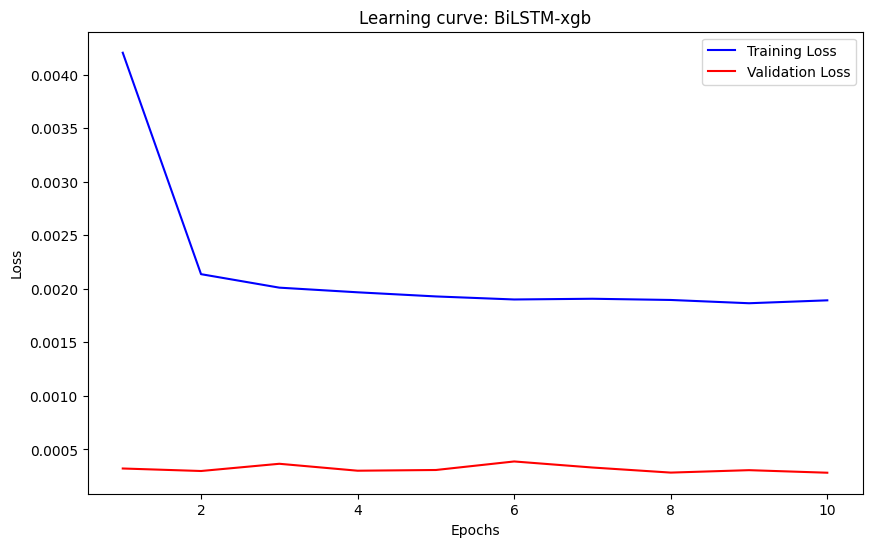

In [19]:
plot_learning_curve(history_xgb, 'BiLSTM-xgb')

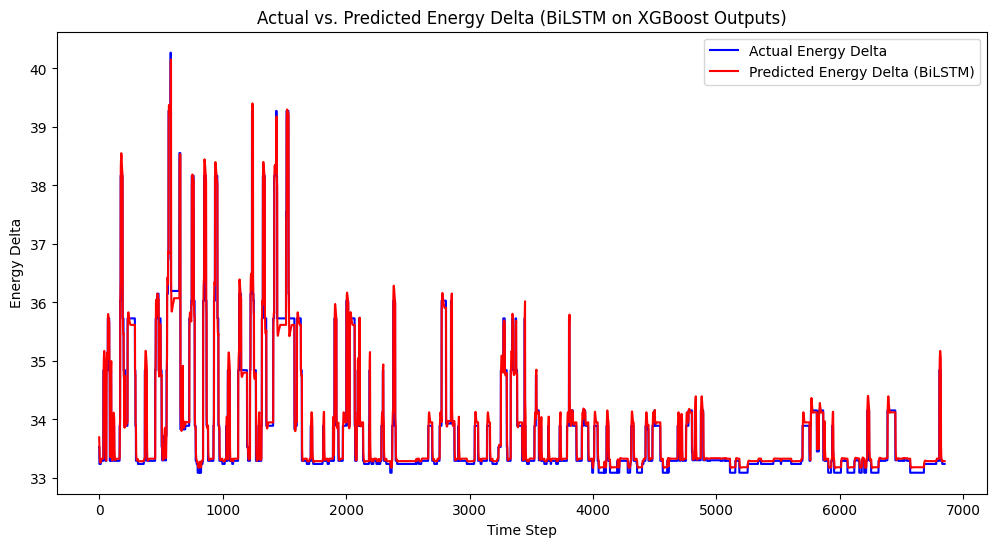

In [20]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_xgb_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_xgb, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on XGBoost Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [21]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data
catboost = CatBoostRegressor(n_estimators=100, learning_rate=0.001, depth=5)

catboost.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
catboost_output_train = catboost.predict(X_train)
catboost_output_test = catboost.predict(X_test)

# Evaluate model performance on training and test sets 
evaluate_model(y_train, catboost_output_train, 'Catboost', 'Training')
evaluate_model(y_test, catboost_output_test, 'Catboost', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()

catboost_output_train_scaled = scaler.fit_transform(catboost_output_train.reshape(-1, 1))
catboost_output_test_scaled = scaler.transform(catboost_output_test.reshape(-1, 1))

# Create BiLSTM input for all three model outputs
X_train_bilstm_catboost, y_train_bilstm_catboost = create_dataset(catboost_output_train_scaled, time_step)
X_test_bilstm_catboost, y_test_bilstm_catboost = create_dataset(catboost_output_test_scaled, time_step)

X_train_bilstm_catboost = X_train_bilstm_catboost.reshape(X_train_bilstm_catboost.shape[0], time_step, 1)
X_test_bilstm_catboost = X_test_bilstm_catboost.reshape(X_test_bilstm_catboost.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on CatBoost outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_catboost = model.fit(X_train_bilstm_catboost, y_train_bilstm_catboost, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_catboost, y_test_bilstm_catboost), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_catboost_scaled = model.predict(X_test_bilstm_catboost)
y_pred_bilstm_catboost = scaler.inverse_transform(y_pred_bilstm_catboost_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_catboost_actual_rescaled = scaler.inverse_transform(y_test_bilstm_catboost.reshape(-1, 1))

evaluate_model(y_test_bilstm_catboost_actual_rescaled, y_pred_bilstm_catboost, 'BiLSTM (CatBoost)', 'Testing')

0:	learn: 53.1408742	total: 60ms	remaining: 5.94s
1:	learn: 53.1200464	total: 61.3ms	remaining: 3s
2:	learn: 53.1001715	total: 62.5ms	remaining: 2.02s
3:	learn: 53.0794931	total: 63.7ms	remaining: 1.53s
4:	learn: 53.0590393	total: 64.9ms	remaining: 1.23s
5:	learn: 53.0387045	total: 66ms	remaining: 1.03s
6:	learn: 53.0182178	total: 67.1ms	remaining: 891ms
7:	learn: 52.9976963	total: 68.2ms	remaining: 784ms
8:	learn: 52.9768773	total: 69.2ms	remaining: 700ms
9:	learn: 52.9569901	total: 70.4ms	remaining: 633ms
10:	learn: 52.9368437	total: 71.6ms	remaining: 579ms
11:	learn: 52.9166222	total: 72.8ms	remaining: 534ms
12:	learn: 52.8962326	total: 73.9ms	remaining: 495ms
13:	learn: 52.8757124	total: 75ms	remaining: 461ms
14:	learn: 52.8557313	total: 76.2ms	remaining: 432ms
15:	learn: 52.8353028	total: 77.3ms	remaining: 406ms
16:	learn: 52.8151920	total: 78.3ms	remaining: 382ms
17:	learn: 52.7949660	total: 79.3ms	remaining: 361ms
18:	learn: 52.7746996	total: 80.4ms	remaining: 343ms
19:	learn: 5

plot saved to /Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/GBDT-BILSTM/assets/learning_curves/multi_variate/Bilstm-catboost_learning_curve.png


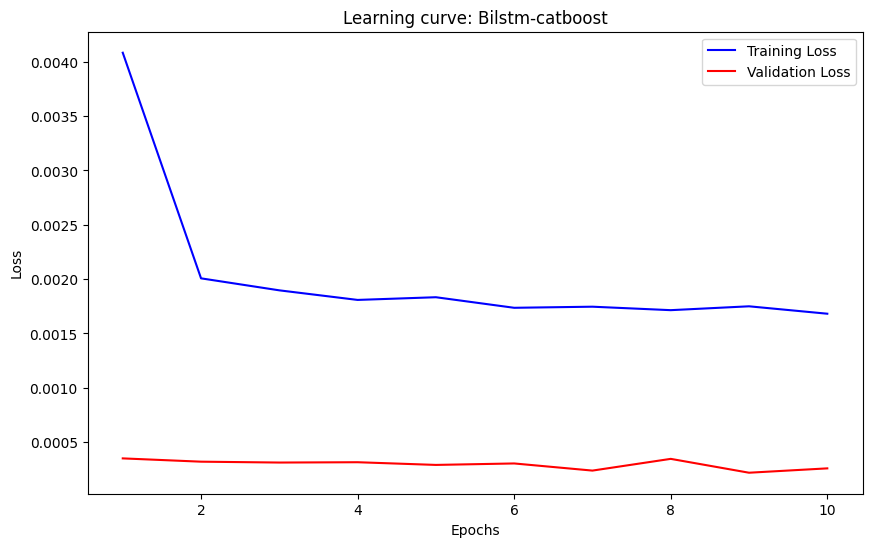

In [23]:
plot_learning_curve(history_catboost, 'Bilstm-catboost')

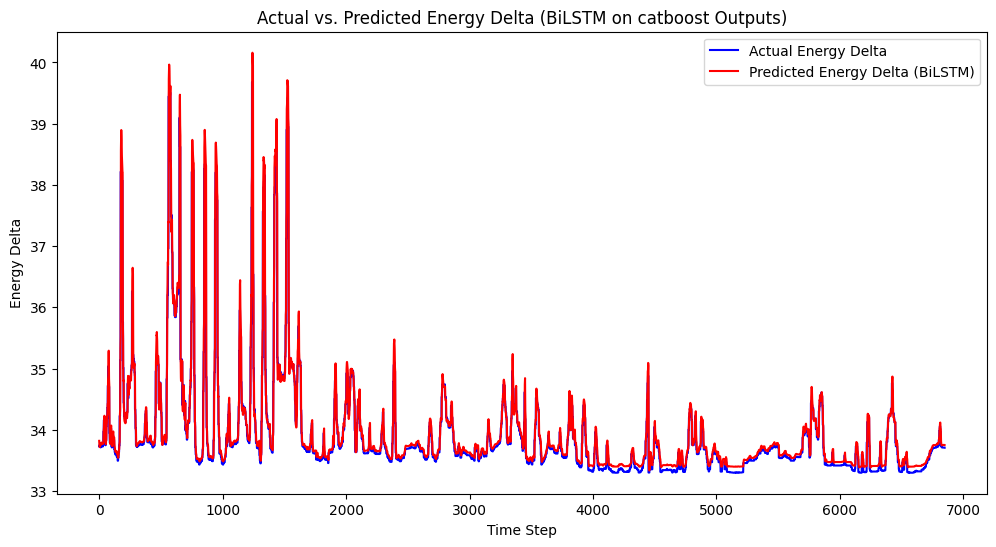

In [24]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_catboost_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_catboost, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on catboost Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [25]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data
lgbm = LGBMRegressor(n_estimators=100, learning_rate=0.001, max_depth=5)

lgbm.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
lgbm_output_train = lgbm.predict(X_train)
lgbm_output_test = lgbm.predict(X_test)


# Evaluate model performance on training and test sets
evaluate_model(y_train, lgbm_output_train, 'LightGBM', 'Training')
evaluate_model(y_test, lgbm_output_test, 'LightGBM', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()
lgbm_output_train_scaled = scaler.fit_transform(lgbm_output_train.reshape(-1, 1))
lgbm_output_test_scaled = scaler.transform(lgbm_output_test.reshape(-1, 1))

# Create BiLSTM input for all three model outputs
X_train_bilstm_lgbm, y_train_bilstm_lgbm = create_dataset(lgbm_output_train_scaled, time_step)
X_test_bilstm_lgbm, y_test_bilstm_lgbm = create_dataset(lgbm_output_test_scaled, time_step)

# Reshape X to be (samples, time_steps, features)
X_train_bilstm_lgbm = X_train_bilstm_lgbm.reshape(X_train_bilstm_lgbm.shape[0], time_step, 1)
X_test_bilstm_lgbm = X_test_bilstm_lgbm.reshape(X_test_bilstm_lgbm.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on GBDT outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_lgbm = model.fit(X_train_bilstm_lgbm, y_train_bilstm_lgbm, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_lgbm, y_test_bilstm_lgbm), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_lgbm_scaled = model.predict(X_test_bilstm_lgbm)
y_pred_bilstm_lgbm = scaler.inverse_transform(y_pred_bilstm_lgbm_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_lgbm_actual_rescaled = scaler.inverse_transform(y_test_bilstm_lgbm.reshape(-1, 1))
evaluate_model(y_test_bilstm_lgbm_actual_rescaled, y_pred_bilstm_lgbm, 'BiLSTM (LightGBM)', 'Testing')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 27494, number of used features: 3
[LightGBM] [Info] Start training from score 36.031094
dataset shape (27494, 1)
dataset shape (6874, 1)
Training BiLSTM on GBDT outputs...


Epoch 1/10
430/430 [==============================] - 51s 115ms/step - loss: 0.0048 - val_loss: 4.2974e-04
Epoch 2/10
430/430 [==============================] - 54s 125ms/step - loss: 0.0026 - val_loss: 3.9555e-04
Epoch 3/10
430/430 [==============================] - 58s 134ms/step - loss: 0.0024 - val_loss: 4.9336e-04
Epoch 4/10
430/430 [==============================] - 54s 125ms/step - loss: 0.0024 - val_loss: 4.7503e-04
Epoch 5/10
430/430 [==============================] - 54s 125ms/step - loss: 0.00

plot saved to /Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/GBDT-BILSTM/assets/learning_curves/multi_variate/BiLSTM-lightgbm_learning_curve.png


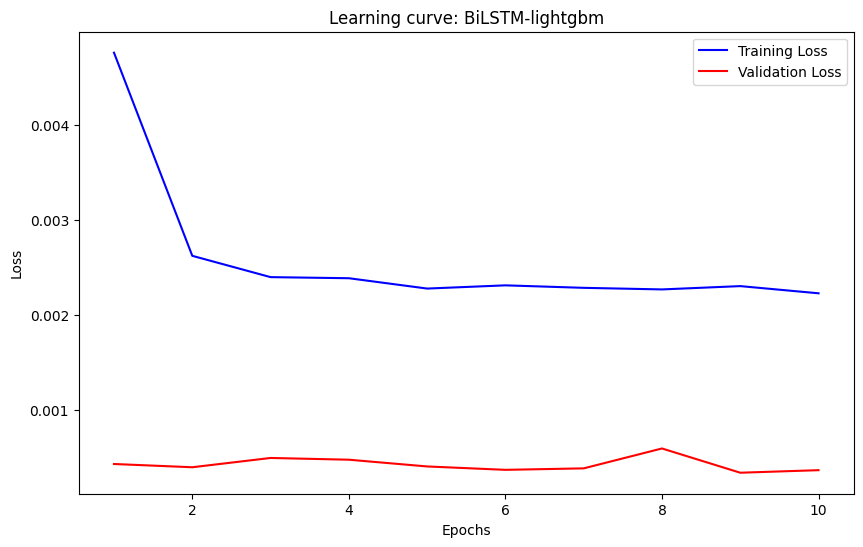

In [27]:
plot_learning_curve(history_lgbm, 'BiLSTM-lightgbm')

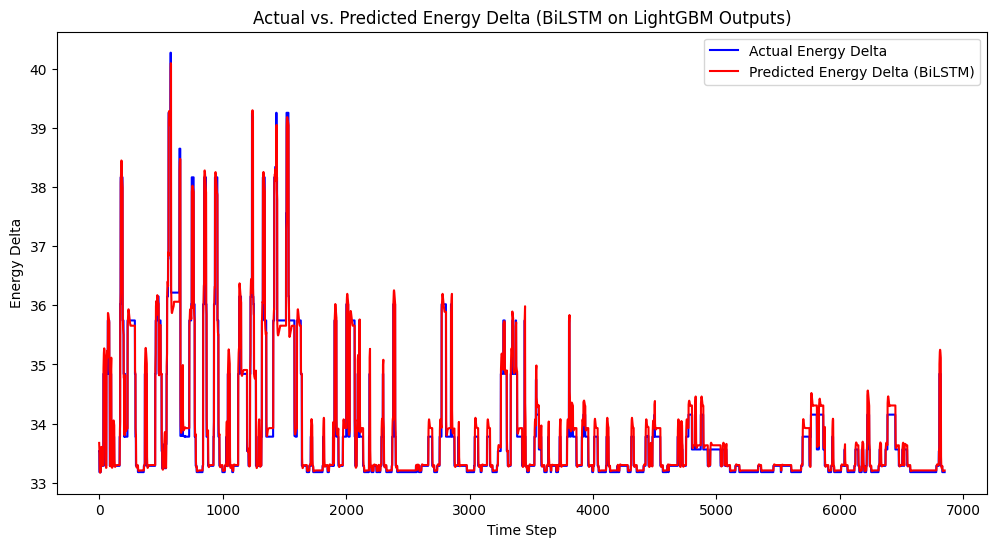

In [ ]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
# dates = pd.date_range(start=month"-01-01", periods=len(y_test_bilstm_lgbm_actual_rescaled), freq="M")

plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_lgbm_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_lgbm, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on LightGBM Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [29]:
results_df = pd.DataFrame(evaluation_results)
print("\nevaluation metrics table: ")


evaluation metrics table: 


In [30]:
results_df

,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Training,4.797767,72.051839,8.488335,0.974514
1,BiLSTM,Testing,3.355258,22.697167,4.764154,0.908103
2,GBDT,Training,40.499283,2593.461501,50.926040,0.082343
3,GBDT,Testing,29.299834,932.216478,30.532220,-2.775613
4,BiLSTM (GBDT),Testing,0.142066,0.070496,0.265511,0.941633
5,XGB,Training,40.501535,2594.010234,50.931427,0.082149
6,XGB,Testing,29.300943,932.284438,30.533333,-2.775889
7,BiLSTM (XGB),Testing,0.102938,0.063490,0.251972,0.947212
8,Catboost,Training,40.728795,2625.913221,51.243665,0.070861
9,Catboost,Testing,29.427135,940.201156,30.662700,-2.807953


In [31]:
from tensorflow.keras import backend as K
K.clear_session()
